In [20]:
from functools import partial
from pathlib import Path
from turtle import color
from setuptools_scm import meta
import torch
import numpy as np
import matplotlib.pyplot as plt

from sbi.inference import simulate_for_sbi

from hnpe.misc import make_label
from hnpe.posterior import build_flow, IdentityJRNMM, get_posterior
from hnpe.simulator import prior_JRNMM, simulator_JRNMM, get_ground_truth
from hnpe.summary import summary_JRNMM
from hnpe.plot import plot_pairgrid_with_groundtruth

from diagnostics.pp_plots import multi_cde_pit_values, PP_plot_1D

from data.feature_transforms import identity


## SBI Task: Inference of the JR-NMM parameters under uniform prior


- Prior: `torch.Size([1, 4])`
    $$p(\theta) = \mathcal{U}([10,250], [50,500], [100,5000],[-20,20])$$
- Simualtor (JR-NMM): `torch.Size([1, 1024])`
    $$x \sim \text{Simulator}(\theta) \approx p(x\mid \theta) \text{, where} \theta = (C, \mu, \sigma, g)$$
- Summary Statistics (Fourier log Power Spectral Density): `torch.Size([1, 33])`
    $$s(x) = \text{log-PSD}(x)$$

**Goal:** estimate $p(\theta\mid x_0)$ with a Normalizing Flow $q_{\phi}(\theta \mid s(x_0))$ with $x_0$ an observation genreated from ground-truth parameters $\theta_0 = (C_0, \mu_0, \sigma_0, g_0)$.

### Experimental SETUP

#### Global Variables

In [21]:
# PATH
PATH_EXPERIMENT = 'saved_experiments/JR-NMM/'

# DATASETS
B = 50_000
B_PRIME = 10_000
B_DOUBLE_PRIME = 10_000
N_SAMPLES_POSTERIOR = 10_000

# DATA FEATURES
N_EXTRA = 0
SINGLE_REC = False
# ground-truth gain parameter
GT_GAIN = -10

# MODEL FEATURES
NAIVE = True  # use NAIVE OR HNPE
METHOD = 'naive'*NAIVE + 'hnpe'*(1-NAIVE)

#### Meta-parameters

In [22]:
meta_parameters = {}
# Data features
meta_parameters['t_recording'] = 8
meta_parameters['n_extra'] = N_EXTRA
# Summary Features
meta_parameters["summary"] = "Fourier"
meta_parameters["n_sf"] = 33
# Training Features
meta_parameters["n_rd"] = 1  # amortized flow
meta_parameters["n_sr"] = B  # simulations per round

# example cases we are considering here
meta_parameters["case"] = PATH_EXPERIMENT+"Flows_amortized/JRNMM_nextra_{:02}_" \
                "naive_{}_" \
                "single_rec_{}".format(N_EXTRA,
                                    NAIVE,
                                    SINGLE_REC)

# label for saving directory of experiments
meta_parameters["label"] = make_label(meta_parameters)
folderpath = Path.cwd() / meta_parameters["label"]


#### Prior, Simulator and Summary Statistics

In [23]:
# Prior
prior = prior_JRNMM(parameters=[('C', 10.0, 250.0),
                                ('mu', 50.0, 500.0),
                                ('sigma', 100.0, 5000.0),
                                ('gain', -20.0, +20.0)])

# Simulator
simulator = partial(simulator_JRNMM,
                    input_parameters=['C', 'mu', 'sigma', 'gain'],
                    t_recording=meta_parameters['t_recording'],
                    n_extra=N_EXTRA,
                    p_gain=prior,
                    single_recording=False)  

# Summary features
summary_extractor = summary_JRNMM(n_extra=N_EXTRA,
                            d_embedding=meta_parameters['n_sf'],
                            n_time_samples=int(128*meta_parameters['t_recording']),
                            type_embedding=meta_parameters['summary'])
summary_extractor.embedding.net.logscale = True  # log-PSD         

#### Ground-truth parameters and observation

In [24]:
# ground-truth parameters to generate observation
theta_true = torch.FloatTensor([135.0, 220.0, 2000.0, GT_GAIN])
meta_parameters['theta'] = theta_true

# choose the ground truth observation to consider in the inference
filename = PATH_EXPERIMENT+f'gt_observations/nextra_{N_EXTRA}/gt_observation_gain_{GT_GAIN}.pkl'
if N_EXTRA > 0:
    filename = filename[:-4]+f"_single_rec_{SINGLE_REC}.pkl"
if os.path.exists(filename):
    x_obs = torch.load(filename)
else:
    ground_truth = get_ground_truth(meta_parameters,
                                input_parameters=['C', 'mu', 'sigma', 'gain'],
                                p_gain=prior, single_recording=SINGLE_REC)
    ground_truth['observation'] = summary_extractor(ground_truth['observation'])
    x_obs = ground_truth['observation'] # torch.Size([1, 33, n_extra+1])
    torch.save(x_obs, filename)


### Load trained Estimator
In what follows, the estimator will try to approximate the posterior $p(\theta \mid x_0)$ with samples from the joint $(x_i, \theta_i) \sim p(x\mid \theta_i)p(\theta_i)$. 
the estimator actually trains on the summary statisctics of the time series $x_i = \text{Summary}(\text{Simulator}(\theta_i))$. 

In [25]:
filename = PATH_EXPERIMENT+f'posteriors_amortized/{METHOD}_posterior_nextra_{N_EXTRA}_single_rec_{SINGLE_REC}_nsim_{B}.pkl'
if os.path.exists(filename):
        posterior = torch.load(filename)
else: 
    # choose a function which creates a neural network density estimator
    build_nn_posterior = partial(build_flow, 
                                embedding_net=IdentityJRNMM(),
                                naive=NAIVE,
                                aggregate=True,
                                z_score_theta=True,
                                z_score_x=True)  

    # get posterior 
    posterior = get_posterior(
        simulator, prior, summary_extractor, build_nn_posterior,
        meta_parameters, round_=0
    ).net
    torch.save(posterior, filename)

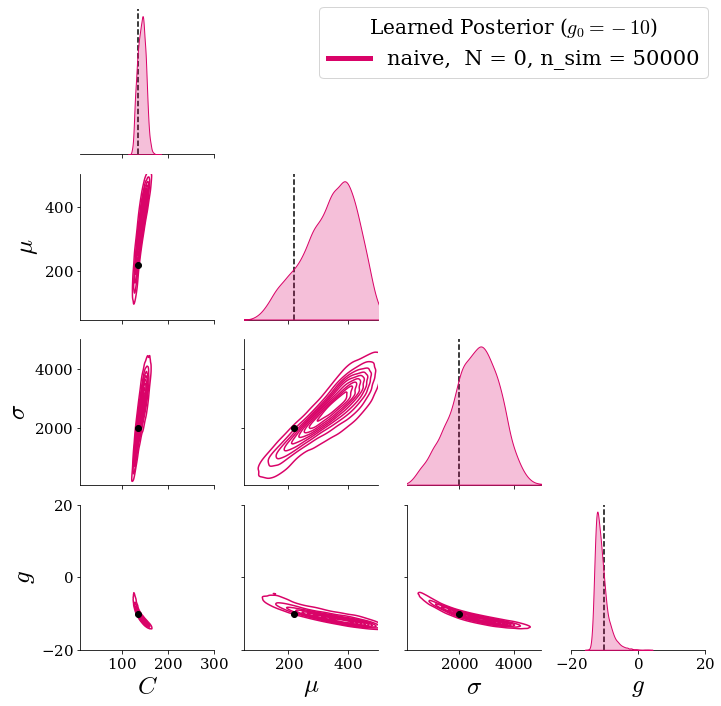

In [26]:
# Plot learned posteriors with true parameters 
cases = [{'method': METHOD, 'n_extra': N_EXTRA, 'gt_gain': GT_GAIN, 'n_sim': B,'single_rec': SINGLE_REC},]

posteriors = {}
context = {}
for exp in cases:
    filename_posterior = PATH_EXPERIMENT+f"posteriors_amortized/naive_posterior_nextra_{exp['n_extra']}_single_rec_{exp['single_rec']}_nsim_{exp['n_sim']}.pkl"
    filename_xobs = PATH_EXPERIMENT+f"gt_observations/nextra_{exp['n_extra']}/gt_observation_gain_{exp['gt_gain']}.pkl"
    if exp['n_extra'] > 0:
        filename_xobs = filename[:-4]+f"_single_rec_{exp['single_rec']}.pkl"
    
    label = f"{exp['method']},  N = {exp['n_extra']}, n_sim = 50000"
    posteriors[label]= torch.load(filename_posterior)
    context[label] = torch.load(filename_xobs)

color_dict = dict(zip(list(posteriors.keys()), ['#D90368', 'blue', '#FFA500']))

plot_pairgrid_with_groundtruth(
    posteriors=posteriors,
    context = context,
    theta_gt=list(theta_true.numpy()),
    color_dict=color_dict,
    handles=[
        plt.Line2D([], [], color=color_dict[label], linewidth=5, label=label) for label in list(posteriors.keys())
    ],
    n_samples=N_SAMPLES_POSTERIOR,
    title = r'Learned Posterior ($g_0=-10$)'
)


## Validation

### Dataset generation

In [15]:
# Simulate Data, create datasets
filename = PATH_EXPERIMENT + f"datasets_{METHOD}.pkl"

if os.path.exists(filename):
    datasets = torch.load(filename)
else:
    # b_theta, b_x = data_gen.get_joint_data(B)
    b_prime_theta, b_prime_x = simulate_for_sbi(
        simulator=simulator, proposal=prior, num_simulations=B_PRIME
    )
    b_prime_x = summary_extractor(b_prime_x)
    b_double_prime_theta, b_double_prime_x = simulate_for_sbi(
        simulator=simulator, proposal=prior, num_simulations=B_DOUBLE_PRIME
    )
    b_double_prime_x = summary_extractor(b_double_prime_x)

    datasets = {
        # "B": {"theta": b_theta, "x": b_x},
        "B_prime": {"theta": b_prime_theta, "x": b_prime_x},
        "B_double_prime": {"theta": b_double_prime_theta, "x": b_double_prime_x},
    }
    torch.save(datasets, filename)

datasets['B_prime']['theta'].shape, datasets['B_prime']['x'].shape

(torch.Size([10000, 4]), torch.Size([10000, 33, 1]))

### Global vs. Local Coverage (`n_extra = 0`)

#### Global Coverage: Expected PIT-distribution

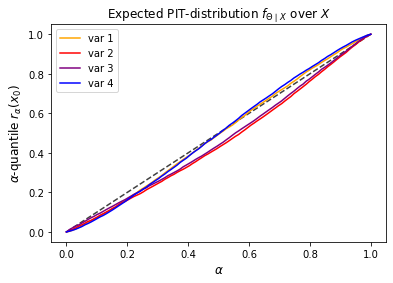

In [16]:
# PLOT EXPECTED PIT-DISTRIBUTION of the trained estimators
theta_test, x_test = datasets['B_prime']['theta'], datasets['B_prime']['x']

# Compute PIT-values of the flows 
# [PIT(Theta_i, X_i, maf_good) = F_{Q_good|X_i}(Theta_i)
flow_joint_pit_values = multi_cde_pit_values(
    theta_test, x_test, posterior, feature_transform=identity
)

# PP-plot of expected PIT-distribution for both flows
# alpha-quantiles = [P_X,Theta(Z < alpha)]
PP_plot_1D(
    PIT_values=[flow_joint_pit_values[0], flow_joint_pit_values[1], flow_joint_pit_values[2], flow_joint_pit_values[3]],
    alphas=np.linspace(0, 1, 100),
    colors=["orange", "red", "purple", "blue"],
    labels=["var 1", "var 2", "var 3", "var 4"],
    title=r"Expected PIT-distribution $f_{\Theta \mid X}$ over $X$",
)

#### Local Coverage: Local PIT-distribution

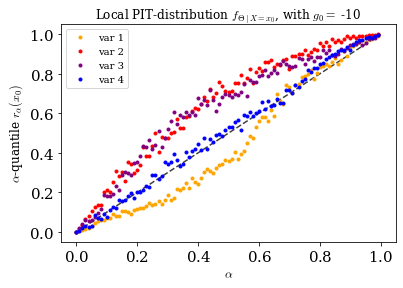

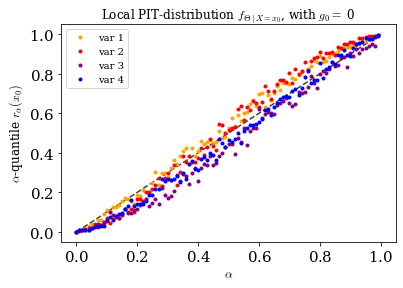

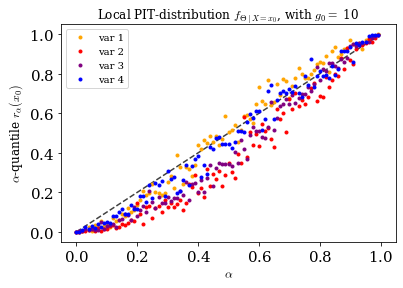

In [19]:
# PLOT LOCAL PIT-DISTRIBUTION of the trained amortized estimators

# Load LEARNED local PIT-values
for gt_gain in [-10, 0, 10]:
    filename = PATH_EXPERIMENT + f"r_alpha_learned/r_alpha_learned_{METHOD}_nextra_{N_EXTRA}_single_rec_{SINGLE_REC}_nsim_{B}_gain_{gt_gain}.pkl"
    r_alpha_learned = torch.load(filename)

    # PP-plot of local PIT-distribution for both flows
    # alpha-quantiles = [P_Theta|X_0(Z < alpha)]
    PP_plot_1D(
        PIT_values=None,
        alphas=np.linspace(0, 0.99, 100),
        r_alpha_learned=[
            r_alpha_learned["dim_1"],
            r_alpha_learned["dim_2"],
            r_alpha_learned["dim_3"],
            r_alpha_learned["dim_4"],
        ],
        colors=["orange", "red"],
        colors_r_alpha=["orange", "red", "purple", "blue"],
        labels=["var 1", "var 2", "var 3", "var 4"],
        title=r"Local PIT-distribution $f_{\Theta \mid X=x_0}$, with $g_0 = $ "+f"{gt_gain}",
    )
